# Predict Renewal Likelihood
# Ali Nikkhah
# Autocad_2021_Data Science Internship

In [272]:
import pandas as pd
import sqlite3
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, precision_recall_fscore_support, roc_curve, f1_score
from sklearn.linear_model import LogisticRegression

In [273]:
#read the CSV and convert them to Dataframe
df_op = pd.read_csv(r'C:\Users\19498\Desktop\sample_opps.csv')
df_ev = pd.read_csv(r'C:\Users\19498\Desktop\sample_event_history.csv')

## Part 1 (SQL)

In [275]:
#connect to a database
connection = sqlite3.connect("Autodesk_2021.db") #Creates a Autodesk_2021.db file in the current directory
#store table in the database:
df_op.to_sql('Opportunity', connection)
df_ev.to_sql('Event', connection)


## Average number of projects per organization

You can find number of projects for each organizations in below (sort by number of projects):

In [277]:
sql_1 = 'SELECT ORGANIZATION_ID,Count(Distinct PROJECT_ID) AS "Number_of_Projects" \
FROM Event \
Group By ORGANIZATION_ID \
Order By Number_of_Projects Desc'
df1 = pd.read_sql(sql_1, connection)
print(df1.to_string(index=False))


ORGANIZATION_ID  Number_of_Projects
           org2                3361
          org33                1703
          org39                 951
           org9                 653
          org13                 616
          org24                 506
         org100                 465
         org112                 443
          org23                 404
          org18                 402
          org88                 367
           org8                 347
          org85                 334
          org16                 298
         org275                 287
           org1                 280
          org11                 279
         org137                 267
         org108                 258
          org54                 243
          org61                 228
          org26                 221
          org30                 218
         org392                 196
          org46                 192
         org109                 191
         org152             

In [278]:
sql_2 = 'Select AVG(Number_of_Projects) AS "Average_Number_of_Projects" \
From (SELECT Count(Distinct PROJECT_ID) AS "Number_of_Projects" FROM Event Group By ORGANIZATION_ID)'
df2 = pd.read_sql(sql_2, connection)
print(df2.to_string(index=False))


 Average_Number_of_Projects
                   43.69103


So average number of projects per organization is 44.

Note that we ignore rows with Null value for "PROJECT_ID" (it's about 7 percent of rows). That's why we can see 0 project for some organizations in the above table. It means those organizations do not have any Non_Null "PROJECT_ID". 

In [14]:
round(df_ev.isnull().sum()*100/len(df_ev),2) # 7 percent of rows do not have "PROJECT_ID"

ACCOUNT_ID         0.00
ORGANIZATION_ID    0.00
USER_ID            0.00
PROJECT_ID         6.79
EVENT_TIME         0.00
EVENT_TYPE         0.00
EVENT_COUNT        0.00
dtype: float64

## Number of projects using feature category “issue” for each account

In [15]:
sql_3 = 'SELECT ACCOUNT_ID,Count(Distinct PROJECT_ID) AS "Number_of_Projects" \
FROM Event \
Where EVENT_TYPE like ("issue%") \
Group By ACCOUNT_ID \
Order By Number_of_Projects Desc'
df3 = pd.read_sql(sql_3, connection)
print(df3.to_string(index=False))


ACCOUNT_ID  Number_of_Projects
    acc399                1157
    acc479                 896
    acc395                 338
    acc131                 313
    acc396                 189
    acc173                 167
    acc189                 154
    acc427                 144
    acc492                 141
    acc113                 125
    acc432                 121
    acc413                 115
    acc450                 112
     acc28                 109
    acc516                 104
    acc526                  97
    acc476                  94
    acc153                  87
    acc416                  86
    acc418                  85
    acc406                  79
    acc393                  63
    acc468                  57
    acc521                  56
    acc430                  55
     acc50                  54
    acc444                  54
    acc435                  54
     acc22                  54
    acc527                  53
    acc459                  51
    acc4

So you can find number of projects per account using feature category "issue" above (sort by number of projects). Note that a we ignore rows with Null value for "PROJECT_ID"

## Find the top 10 OPPORTUNITY_ID having triggered the highest number of event types

I can interpret this question as two ways.

First, I show top oppurtunities which triggered the highest number of unique event types ("Event_Count" does not matter and we ignore repeated "Event_Types"). Also, we show 11 opportunities instead of 10, because they are equal. 

In [16]:
sql_4 = 'Select Distinct(t1.OPPORTUNITY_ID),t1.ACCOUNT_ID,t2.Number_of_Event_Type \
From Opportunity t1,(SELECT ACCOUNT_ID,Count(Distinct EVENT_TYPE) AS "Number_of_Event_Type" FROM Event Group By ACCOUNT_ID) t2 \
Where t1.ACCOUNT_ID=t2.ACCOUNT_ID \
Order By t2.Number_of_Event_Type Desc \
Limit 11'

df4 = pd.read_sql(sql_4, connection)
print(df4.to_string(index=False))

OPPORTUNITY_ID ACCOUNT_ID  Number_of_Event_Type
        opp397     acc395                  1010
        opp398     acc395                  1010
        opp399     acc395                  1010
        opp400     acc395                  1010
        opp401     acc395                  1010
        opp402     acc395                  1010
        opp406     acc399                   963
        opp407     acc399                   963
        opp435     acc427                   781
        opp500     acc492                   777
        opp501     acc492                   777


Second, I show top oppurtunities which triggered the highest number of event types. We count all event types (including "Event_Count").  

In [17]:
sql_5 = 'Select Distinct(t1.OPPORTUNITY_ID),t1.ACCOUNT_ID,t2.Number_of_Event \
From Opportunity t1,(SELECT ACCOUNT_ID,Sum(EVENT_COUNT) AS "Number_of_Event" FROM Event Group By ACCOUNT_ID) t2 \
Where t1.ACCOUNT_ID=t2.ACCOUNT_ID \
Order By t2.Number_of_Event Desc \
Limit 10'

df5 = pd.read_sql(sql_5, connection)
print(df5.to_string(index=False))

OPPORTUNITY_ID ACCOUNT_ID  Number_of_Event
        opp406     acc399          8916702
        opp407     acc399          8916702
        opp397     acc395          6123601
        opp398     acc395          6123601
        opp399     acc395          6123601
        opp400     acc395          6123601
        opp401     acc395          6123601
        opp402     acc395          6123601
        opp435     acc427          2043688
        opp403     acc396          1957065


# Part 2 (Machine Learning)

## Feature Engineering

### Opurtunity Table

In [279]:
df_op.head()

,ACCOUNT_ID,OPPORTUNITY_ID,RENEWAL_DATE_C,PRODUCT_CODE,NAME,QUANTITY,START_DATE_C,END_DATE_C,IS_WON
0,acc1,opp1,2020-04-23,SS_550_AN_P2,PlanGrid (Nailgun - 550 Sheets),4,2020-04-24,2021-04-23,NaN
1,acc1,opp1,2020-04-23,SS_5K_AN_P2,PlanGrid (Dozer - 5000 Sheets),2,2020-04-24,2021-04-23,NaN
2,acc2,opp2,2020-04-16,SS_INF_AN_P2,PlanGrid (Crane - Infinite Sheets),1,2020-04-17,2021-04-16,True
3,acc2,opp2,2020-04-16,SS_5K_AN_P2,PlanGrid (Dozer - 5000 Sheets),8,2020-04-17,2021-04-16,True
4,acc3,opp3,2020-04-09,SS_5K_AN_P2,PlanGrid (Dozer - 5000 Sheets),3,2020-04-10,2021-04-09,True


In [280]:
# We just keep these columns, becasue others do not effect our target value
df_op2=df_op[['OPPORTUNITY_ID','RENEWAL_DATE_C','ACCOUNT_ID','NAME','IS_WON']]
df_op2.head()

,OPPORTUNITY_ID,RENEWAL_DATE_C,ACCOUNT_ID,NAME,IS_WON
0,opp1,2020-04-23,acc1,PlanGrid (Nailgun - 550 Sheets),NaN
1,opp1,2020-04-23,acc1,PlanGrid (Dozer - 5000 Sheets),NaN
2,opp2,2020-04-16,acc2,PlanGrid (Crane - Infinite Sheets),True
3,opp2,2020-04-16,acc2,PlanGrid (Dozer - 5000 Sheets),True
4,opp3,2020-04-09,acc3,PlanGrid (Dozer - 5000 Sheets),True


In [281]:
df_op2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   OPPORTUNITY_ID  1000 non-null   object
 1   RENEWAL_DATE_C  1000 non-null   object
 2   ACCOUNT_ID      1000 non-null   object
 3   NAME            1000 non-null   object
 4   IS_WON          580 non-null    object
dtypes: object(5)
memory usage: 39.2+ KB


We can see that type of "RENEWAL_DATE_C" is not Date, so we should convert it.

In [ ]:
df_op2.RENEWAL_DATE_C= pd.to_datetime(df_op2.RENEWAL_DATE_C,format='%Y-%m-%d')


In [283]:
#Now we can see the Date type
df_op2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   OPPORTUNITY_ID  1000 non-null   object        
 1   RENEWAL_DATE_C  1000 non-null   datetime64[ns]
 2   ACCOUNT_ID      1000 non-null   object        
 3   NAME            1000 non-null   object        
 4   IS_WON          580 non-null    object        
dtypes: datetime64[ns](1), object(4)
memory usage: 39.2+ KB


In [284]:
df_op2.nunique(axis=0)

OPPORTUNITY_ID    536
RENEWAL_DATE_C     30
ACCOUNT_ID        527
NAME               20
IS_WON              2
dtype: int64

"NAME" of products are important for us because it can affect our target value. We can see there are 30 different product name. So we want to know about the distribution of these products

In [285]:
df_op2['NAME'].value_counts(dropna=False)

PlanGrid (Dozer - 5000 Sheets)                           347
PlanGrid (Nailgun - 550 Sheets)                          281
PlanGrid (Crane - Infinite Sheets)                       115
PlanGrid (Workspaces)                                     99
PlanGrid (Admin Console)                                  97
PlanGrid (Submittals - Up to 50 Users)                    18
PlanGrid (Advanced RFIs)                                  15
PlanGrid (Enterprise Subscription - Unlimited Sheets)      7
PlanGrid (Developer API Access)                            5
PlanGrid (Automatic Submittal Log - Up to 50 Users)        4
PlanGrid (Quick Start Webinar)                             2
PlanGrid (Single Sign-On - Up to 50 Users)                 2
Connect Platform                                           1
PlanGrid (Automatic Submittal Log - Up to 500 Users)       1
PlanGrid (Submittals - Up to 500 Users)                    1
PlanGrid (Automatic Submittal Log - Up to 200 Users)       1
PlanGrid (Automatic Subm

We just keep 7 of them because others are renew less than 10 times. We categorized them as "Other_Plan" 

In [ ]:
Minor_product=['PlanGrid (Enterprise Subscription - Unlimited Sheets)','PlanGrid (Developer API Access)' \
               ,'PlanGrid (Automatic Submittal Log - Up to 50 Users)','PlanGrid (Quick Start Webinar)' \
               ,'PlanGrid (Single Sign-On - Up to 50 Users)','Connect Platform' \
               ,'PlanGrid (Automatic Submittal Log - Up to 500 Users)','PlanGrid (Submittals - Up to 500 Users)' \
               ,'PlanGrid (Automatic Submittal Log - Up to 200 Users)','PlanGrid (Automatic Submittal Log - Unlimited Users)' \
               ,'PlanGrid (Submittals - Unlimited Users)','PlanGrid (Single Sign-On - Up to 200 Users)' \
               ,'PlanGrid (Submittals - Up to 200 Users)']
for i in Minor_product:
    df_op2['NAME'].replace(i,'Other_Plan',inplace=True)


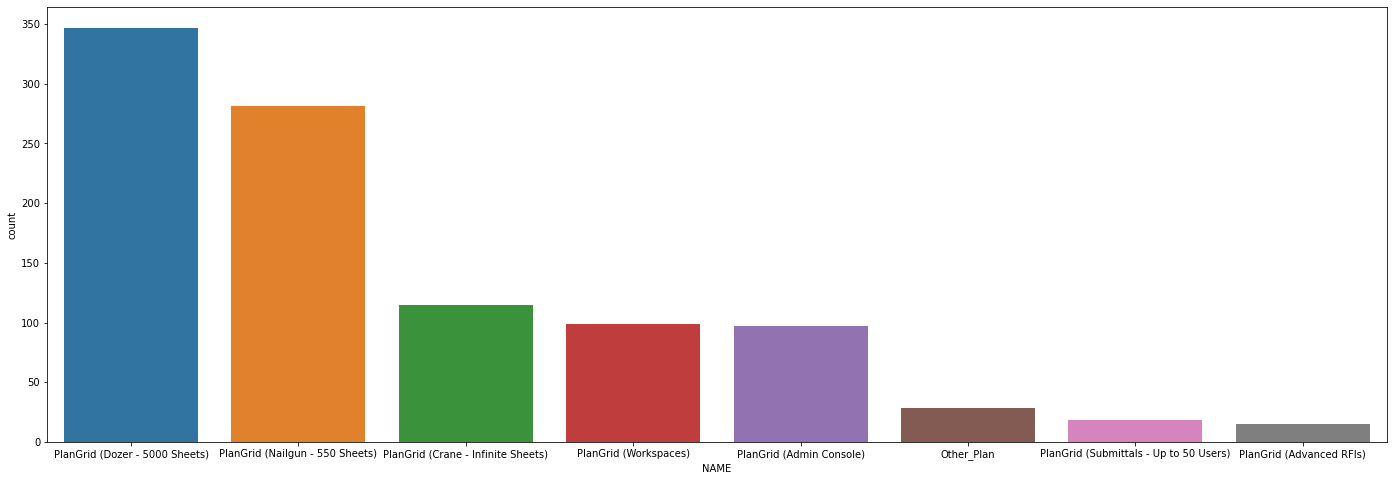

In [287]:
plt.figure(figsize=(24,8))
sns.countplot(data=df_op2, x='NAME',order = df_op2['NAME'].value_counts().index)
plt.show()

In the original table, some opportunities related to more than one products. First we use One-hot encoding "NAME" that creates 8 new features. Then we group the table based on "OPPORTUNITY_ID". So it means now we have just 1 row for each opportunity, and each opportunity related to specefic plan if the value equal to 1. For example, in the below table, you can see thay opp1 is related to two plans (PlanGrid (Dozer - 5000 Sheets) & PlanGrid (Nailgun - 550 Sheets))

In [288]:
df_op3 =df_op2[['OPPORTUNITY_ID','RENEWAL_DATE_C','ACCOUNT_ID','IS_WON']].join(pd.get_dummies(df_op2['NAME'])).groupby('OPPORTUNITY_ID').max()
df_op3.reset_index(inplace=True)
df_op3.head()

,OPPORTUNITY_ID,RENEWAL_DATE_C,ACCOUNT_ID,IS_WON,Other_Plan,PlanGrid (Admin Console),PlanGrid (Advanced RFIs),PlanGrid (Crane - Infinite Sheets),PlanGrid (Dozer - 5000 Sheets),PlanGrid (Nailgun - 550 Sheets),PlanGrid (Submittals - Up to 50 Users),PlanGrid (Workspaces)
0,opp1,2020-04-23,acc1,NaN,0,0,0,0,1,1,0,0
1,opp10,2020-04-23,acc10,NaN,0,0,0,1,1,0,0,0
2,opp100,2020-04-29,acc100,NaN,0,0,0,0,0,1,1,0
3,opp101,2020-04-15,acc101,True,0,1,0,0,1,0,0,0
4,opp102,2020-04-30,acc102,NaN,0,0,0,0,1,0,0,0


### Event Table

In [289]:
df_ev.head()

,ACCOUNT_ID,ORGANIZATION_ID,USER_ID,PROJECT_ID,EVENT_TIME,EVENT_TYPE,EVENT_COUNT
0,acc420,org1,u1,p1,2019-05-10,sheet.view,3
1,acc399,org2,u2,p2,2019-05-06,attachment.list.folder.filter,1
2,acc399,org2,u3,p3,2019-06-24,sheet.list.filter.select,2
3,acc122,org3,u4,p4,2019-04-30,sheet.list.filters.view,1
4,acc61,org4,u5,p5,2019-08-07,sheet.list,1


In [290]:
df_ev.nunique(axis=0)

ACCOUNT_ID           496
ORGANIZATION_ID      602
USER_ID             5209
PROJECT_ID         25071
EVENT_TIME           213
EVENT_TYPE          1180
EVENT_COUNT         1455
dtype: int64

In this table, "EVENT_TYPE" is important feature for us. We can see there is 1180 event types. So we need to group them to decrease the complexity

In [291]:
# Most frequent event Type
100*(df_ev['EVENT_TYPE'].value_counts(dropna=False)[:20])/7226175

sheet.list                 6.084990
sheet.view                 5.820991
project.list.select        5.385270
sheet.links.appear         3.628766
sheet.gesture              2.668230
project.list.scroll        2.023505
project.home.enter         1.977962
attachment.list.view       1.888288
project.update.complete    1.749847
sheet.list.filters.view    1.716302
project.update.download    1.420364
annotation.create          1.295679
sheet.list.filter          1.251506
attachment.view            1.251326
home.pane.click            1.147329
annotation.link.view       1.081208
sheet.sheet.load           1.017551
sheet.list.search          0.913305
project.list.click         0.901653
sheet.list.search.focus    0.882597
Name: EVENT_TYPE, dtype: float64

In [292]:
df_ev2=df_ev.copy()

At the first try, we group "EVENT_TYPE" based on the first word. For example, we group all "issue...." to gether.

In [293]:
d = {'account':'account','annotation':'annotation' \
     ,'attachment':'attachment','comment':'comment','documents':'documents','ec':'ec' \
     ,'field_report':'field_report','home':'home','issue':'issue','link':'link' \
     ,'measurement':'measurement','mention':'mention','more':'more','nav':'nav' \
     ,'onboarding':'onboarding','pg_form':'pg_form','photo':'photo','project.':'project' \
     ,'projecthub':'projecthub','project_profile':'project_profile','pspdfkit':'pspdfkit','punchlist':'punchlist' \
     ,'reference':'reference','rfilist':'rfilist','rfis2':'rfis2','sheet_compare':'sheet_compare' \
     ,'sheet.':'sheet','sheets':'sheets','snapshot':'snapshot','submittals':'submittals','team':'team' \
     ,'tooltip':'tooltip','upload':'upload','version_set':'version_set','workspace':'workspace' \
     ,'rfi':'rfi','bim':'bim','action_center':'action_center','article':'article'\
     ,'asbuilt':'asbuilt','map':'map','feedback_form':'feedback_form','mytags':'mytags' \
     ,'manage_storage':'manage_storage','export':'export','polyline':'polyline','web':'web' \
     ,'learn_plangrid':'learn_plangrid','selfies':'selfies','polycloud':'polycloud' \
     ,'collaborator':'collaborator','whatsnew':'whatsnew'}

for k, v in d.items():
    df_ev2.loc[df_ev2['EVENT_TYPE'].str.startswith(k, na=False), 'EVENT_TYPE'] = v

In [294]:
100*(df_ev2['EVENT_TYPE'].value_counts(dropna=False)[:])/7226175

sheet              41.847644
project            18.811515
annotation          7.229219
attachment          6.808886
issue               6.536709
field_report        2.907140
nav                 2.756756
photo               2.515771
projecthub          2.366286
action_center       1.836421
home                1.445675
link                0.850519
team                0.770754
ec                  0.277865
rfi                 0.273907
comment             0.262324
measurement         0.239131
sheet_compare       0.237000
reference           0.231090
more                0.184067
pspdfkit            0.182351
snapshot            0.170381
article             0.156127
punchlist           0.138151
tooltip             0.136019
account             0.109422
pg_form             0.106585
version_set         0.103457
documents           0.101714
submittals          0.089245
onboarding          0.065678
project_profile     0.061042
mention             0.035261
workspace           0.032673
upload        

So now it is much better. But "Sheet" and "Project" seems very frequent, so we need to break these two. We saw earlier which event_type are most frequent, so we use more detailed event type for these two. Also, we group least frequent ones as "Others"

In [295]:
df_ev3=df_ev.copy()

In [296]:
d = {'account':'Other','annotation':'annotation' \
     ,'attachment':'attachment','comment':'Other','documents':'Other','ec':'Other' \
     ,'field_report':'field_report','home':'home','issue':'issue','link':'link' \
     ,'measurement':'Other','mention':'Other','more':'Other','nav':'nav' \
     ,'onboarding':'Other','pg_form':'Other','photo':'photo' \
     ,'projecthub':'projecthub','pspdfkit':'Other','punchlist':'Other' \
     ,'reference':'Other','rfilist':'rfilist','rfis2':'rfis2','sheet_compare':'Other' \
     ,'snapshot':'Other','submittals':'Other','team':'team' \
     ,'tooltip':'Other','upload':'Other','version_set':'Other','workspace':'Other' \
     ,'rfi':'Other','bim':'Other','action_center':'action_center','article':'Other'\
     ,'asbuilt':'Other','map':'Other','feedback_form':'Other','mytags':'Other' \
     ,'manage_storage':'Other','export':'Other','polyline':'Other','web':'Other' \
     ,'learn_plangrid':'Other','selfies':'Other','polycloud':'Other' \
     ,'collaborator':'Other','whatsnew':'Other','update_profile':'Other' \
     ,'project_profile':'Other','sheets':'Other','sheet.list':'_sheet.list' \
     ,'sheet.view':'_sheet.view','project.list':'_project.list' \
     ,'sheet.links':'_sheet.links','sheet.gesture':'_sheet.gesture' \
     ,'project.home':'_project.home','project.update':'_project.update','sheet.sheet':'_sheet.sheet'}

for k, v in d.items():
    df_ev3.loc[df_ev3['EVENT_TYPE'].str.startswith(k, na=False), 'EVENT_TYPE'] = v

In [297]:
d2={'sheet.':'sheet','project.':'project'}
for k, v in d2.items():
    df_ev3.loc[df_ev3['EVENT_TYPE'].str.startswith(k, na=False), 'EVENT_TYPE'] = v

In [298]:
100*(df_ev3['EVENT_TYPE'].value_counts(dropna=False)[:])/7226175

_sheet.list        15.829979
sheet              10.136677
_project.list       9.382184
annotation          7.229219
attachment          6.808886
issue               6.536709
_sheet.view         5.828104
_project.update     4.199898
_sheet.links        3.796601
_sheet.sheet        3.588053
Other               3.316706
project             3.251471
field_report        2.907140
nav                 2.756756
_sheet.gesture      2.668230
photo               2.515771
projecthub          2.366286
_project.home       1.977962
action_center       1.836421
home                1.445675
link                0.850519
team                0.770754
Name: EVENT_TYPE, dtype: float64

In [299]:
df_ev4=df_ev3.copy()

So we reduce "EVENT_type" feature to 22 different categories. Also, you can find the distribution in below. 

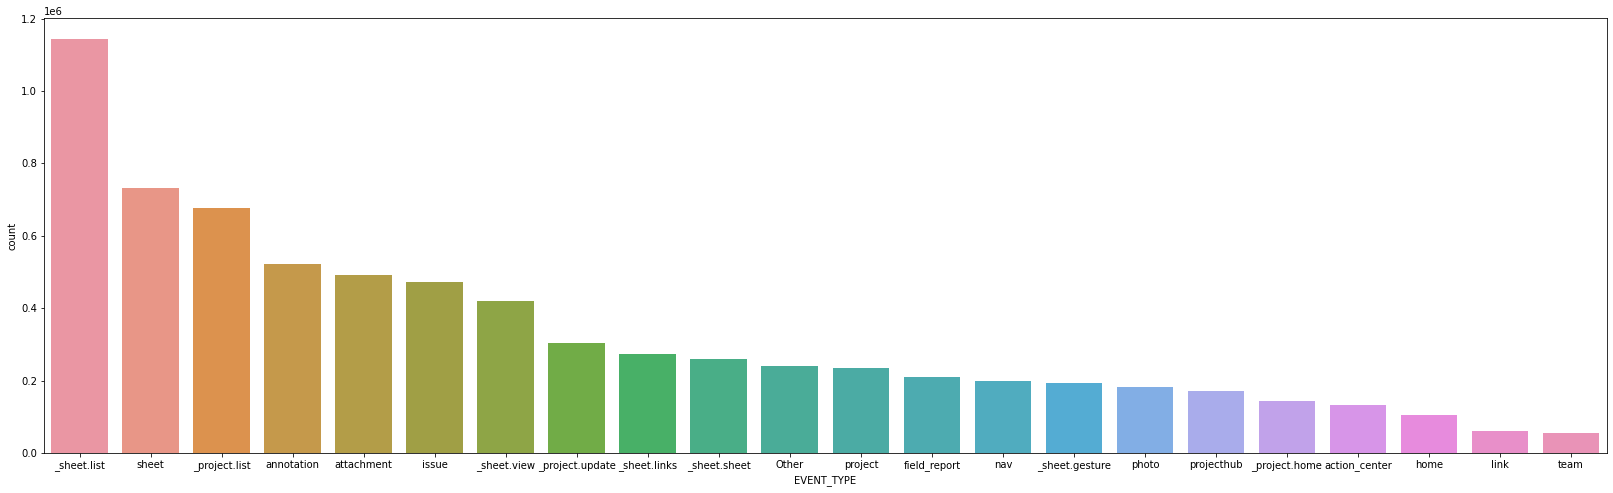

In [300]:
plt.figure(figsize=(28,8))
sns.countplot(data=df_ev4, x='EVENT_TYPE',order = df_ev4['EVENT_TYPE'].value_counts().index)
plt.show()

In [301]:
#We just need these two features from this table. Others do not affect target value
df_ev5=df_ev4[['ACCOUNT_ID','EVENT_TYPE']]

Again, like previous case, we use One-hot encoding for "EVENT_type" and group based on "ACCOUNT_ID". For example, you can find event types for each account in the below

In [302]:
df_ev6 =df_ev5[['ACCOUNT_ID']].join(pd.get_dummies(df_ev5['EVENT_TYPE'])).groupby('ACCOUNT_ID').max()
df_ev6.reset_index(inplace=True)
df_ev6.head()

,ACCOUNT_ID,Other,_project.home,_project.list,_project.update,_sheet.gesture,_sheet.links,_sheet.list,_sheet.sheet,_sheet.view,...,field_report,home,issue,link,nav,photo,project,projecthub,sheet,team
0,acc1,1,1,1,0,0,0,1,1,1,...,0,1,1,0,1,1,1,0,0,1
1,acc10,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,acc100,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,acc101,1,1,1,1,1,1,1,1,1,...,1,0,1,1,1,1,1,0,1,1
4,acc102,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


### Combine Two Tables

In [ ]:

#store table in the database:
df_op3.to_sql('Opportunity_New', connection)
df_ev6.to_sql('Event_New', connection)

In [304]:
sql_7='Select * \
From Opportunity_New t1 Left Join Event_New t2 ON t1.ACCOUNT_ID=t2.ACCOUNT_ID'
df = pd.read_sql(sql_7, connection)


We combine two tables. For each opportunity, we know plans that related to that opportunity as well as  the event types (events for account that related to that opportunity). 

In [397]:
df1=df.copy()

In [398]:
df1.head()

,index,OPPORTUNITY_ID,RENEWAL_DATE_C,ACCOUNT_ID,IS_WON,Other_Plan,PlanGrid (Admin Console),PlanGrid (Advanced RFIs),PlanGrid (Crane - Infinite Sheets),PlanGrid (Dozer - 5000 Sheets),...,field_report,home,issue,link,nav,photo,project,projecthub,sheet,team
0,0,opp1,2020-04-23 00:00:00,acc1,NaN,0,0,0,0,1,...,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0
1,1,opp10,2020-04-23 00:00:00,acc10,NaN,0,0,0,1,1,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,2,opp100,2020-04-29 00:00:00,acc100,NaN,0,0,0,0,0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,3,opp101,2020-04-15 00:00:00,acc101,1.0,0,1,0,0,1,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
4,4,opp102,2020-04-30 00:00:00,acc102,NaN,0,0,0,0,1,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


So, you can see the final table. For each opportunity, we know the plans as well as event type. 

In [399]:
df1.set_index(['OPPORTUNITY_ID'],inplace=True)
df1.drop(['ACCOUNT_ID','index'], axis=1,inplace=True)
df1.head()

,RENEWAL_DATE_C,IS_WON,Other_Plan,PlanGrid (Admin Console),PlanGrid (Advanced RFIs),PlanGrid (Crane - Infinite Sheets),PlanGrid (Dozer - 5000 Sheets),PlanGrid (Nailgun - 550 Sheets),PlanGrid (Submittals - Up to 50 Users),PlanGrid (Workspaces),...,field_report,home,issue,link,nav,photo,project,projecthub,sheet,team
OPPORTUNITY_ID,,,,,,,,,,,,,,,,,,,,,
opp1,2020-04-23 00:00:00,NaN,0,0,0,0,1,1,0,0,...,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0
opp10,2020-04-23 00:00:00,NaN,0,0,0,1,1,0,0,0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
opp100,2020-04-29 00:00:00,NaN,0,0,0,0,0,1,1,0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
opp101,2020-04-15 00:00:00,1.0,0,1,0,0,1,0,0,0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
opp102,2020-04-30 00:00:00,NaN,0,0,0,0,1,0,0,0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


There is event type for some opportunity, so fill those with 0 for them. 

In [400]:
df1.fillna(0, inplace=True)



## Modeling

### Splitting

In [401]:
# Break or dataset to train and test based on "RENEWAL_DATE_C"
df_train=df1[(df1['RENEWAL_DATE_C'] < '2020-04-21')]
df_train.head()

,RENEWAL_DATE_C,IS_WON,Other_Plan,PlanGrid (Admin Console),PlanGrid (Advanced RFIs),PlanGrid (Crane - Infinite Sheets),PlanGrid (Dozer - 5000 Sheets),PlanGrid (Nailgun - 550 Sheets),PlanGrid (Submittals - Up to 50 Users),PlanGrid (Workspaces),...,field_report,home,issue,link,nav,photo,project,projecthub,sheet,team
OPPORTUNITY_ID,,,,,,,,,,,,,,,,,,,,,
opp101,2020-04-15 00:00:00,1.0,0,1,0,0,1,0,0,0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
opp103,2020-04-18 00:00:00,1.0,0,0,0,0,1,0,0,0,...,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
opp104,2020-04-07 00:00:00,1.0,0,1,0,1,1,0,0,0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
opp105,2020-04-02 00:00:00,1.0,0,0,0,0,1,0,0,0,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
opp106,2020-04-14 00:00:00,1.0,0,0,0,1,1,0,0,0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [402]:
df_test=df1[(df1['RENEWAL_DATE_C'] > '2020-04-21')]

Now we need split our traning set to traning and validation. 

In [403]:
Y = df_train['IS_WON']
X = df_train.drop(['RENEWAL_DATE_C','IS_WON'], axis=1)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.3, random_state=42)

### Sampling

Next we want to know if our target value for our traning set is balanced or not.

C:\Users\19498\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='IS_WON', ylabel='count'>

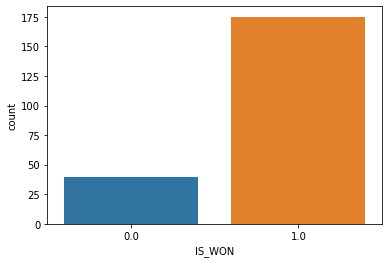

In [404]:
sns.countplot(Y_train)

It seems our dataset is unbalanced. We use SMOTE technique which means to create new synthetic False cases to balance our traning set. Figure below shows the effect of this technique. Note that we just do this for our traning not our validation, because we want them to represent the real test data.  

C:\Users\19498\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='IS_WON', ylabel='count'>

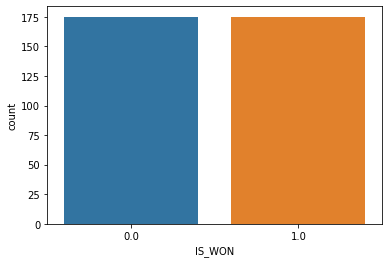

In [405]:
method = SMOTE()
X_train, Y_train=method.fit_sample(X_train, Y_train)
X_train=pd.DataFrame(X_train)
X_train.columns=X.columns
#X_train_s.head()
sns.countplot(Y_train)

### Model Selection

#### Catboost

In [406]:
from catboost import CatBoostClassifier
cb=CatBoostClassifier()
cb.fit(X_train,Y_train)
cb_val = cb.predict(X_val)
cb_pred_train = cb.predict_proba(X_train)[:,1]
cb_pred_val = cb.predict_proba(X_val)[:,1]
cb_train_auc = roc_auc_score(Y_train, cb_pred_train)
cb_val_auc = roc_auc_score(Y_val, cb_pred_val)


Learning rate set to 0.00658
0:	learn: 0.6893183	total: 21.5ms	remaining: 21.5s
1:	learn: 0.6876342	total: 35.4ms	remaining: 17.7s
2:	learn: 0.6847874	total: 51.7ms	remaining: 17.2s
3:	learn: 0.6813060	total: 68.1ms	remaining: 16.9s
4:	learn: 0.6787774	total: 84ms	remaining: 16.7s
5:	learn: 0.6763443	total: 86.1ms	remaining: 14.3s
6:	learn: 0.6741302	total: 99.8ms	remaining: 14.2s
7:	learn: 0.6714293	total: 116ms	remaining: 14.4s
8:	learn: 0.6680119	total: 131ms	remaining: 14.4s
9:	learn: 0.6648492	total: 133ms	remaining: 13.2s
10:	learn: 0.6618549	total: 146ms	remaining: 13.1s
11:	learn: 0.6593071	total: 148ms	remaining: 12.2s
12:	learn: 0.6565280	total: 151ms	remaining: 11.4s
13:	learn: 0.6540080	total: 161ms	remaining: 11.3s
14:	learn: 0.6513661	total: 176ms	remaining: 11.5s
15:	learn: 0.6488926	total: 191ms	remaining: 11.8s
16:	learn: 0.6470987	total: 207ms	remaining: 12s
17:	learn: 0.6438349	total: 208ms	remaining: 11.4s
18:	learn: 0.6413382	total: 210ms	remaining: 10.8s
19:	learn

In [407]:
print('AUC_Training:%.2f'%cb_train_auc)
print('AUC_Validation:%.2f'%cb_val_auc)

AUC_Training:0.97
AUC_Validation:0.78


#### Logistic Regression

In [408]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
lr=LogisticRegression(random_state = 42)
lr.fit(X_train,Y_train)
lr_val = lr.predict(X_val)
lr_pred_train = lr.predict_proba(X_train)[:,1]
lr_pred_val = lr.predict_proba(X_val)[:,1]
lr_train_auc = roc_auc_score(Y_train, lr_pred_train)
lr_val_auc = roc_auc_score(Y_val, lr_pred_val)
print('AUC_Training:%.2f'%lr_train_auc)
print('AUC_Validation:%.2f'%lr_val_auc)


AUC_Training:0.91
AUC_Validation:0.82


#### Random Forest Classifier

In [409]:
rf = RandomForestClassifier(max_depth = 6, random_state = 42) 
rf.fit(X_train,Y_train)
rf_pred_train = rf.predict_proba(X_train)[:,1]
rf_pred_val = rf.predict_proba(X_val)[:,1]
rf_train_auc = roc_auc_score(Y_train, rf_pred_train)
rf_val_auc = roc_auc_score(Y_val, rf_pred_val)
print('AUC_Training:%.2f'%rf_train_auc)
print('AUC_Validation:%.2f'%rf_val_auc)

AUC_Training:0.95
AUC_Validation:0.78


#### Gradient Boosting

In [410]:
#Gradient Boosting
gb = GradientBoostingClassifier() 
gb.fit(X_train,Y_train)
gb_val = gb.predict(X_val)
gb_pred_train = gb.predict_proba(X_train)[:,1]
gb_pred_val = gb.predict_proba(X_val)[:,1]
gb_train_auc = roc_auc_score(Y_train, gb_pred_train)
gb_val_auc = roc_auc_score(Y_val, gb_pred_val)
print('AUC_Training:%.2f'%gb_train_auc)
print('AUC_Validation:%.2f'%gb_val_auc)

AUC_Training:0.97
AUC_Validation:0.76


#### KNN

In [411]:
#KNN
knn = KNeighborsClassifier() 
knn.fit(X_train,Y_train)
knn_pred_train = knn.predict_proba(X_train)[:,1]
knn_pred_val = knn.predict_proba(X_val)[:,1]
knn_train_auc = roc_auc_score(Y_train, knn_pred_train)
knn_val_auc = roc_auc_score(Y_val, knn_pred_val)
print('AUC_Training:%.2f'%knn_train_auc)
print('AUC_Validation:%.2f'%knn_val_auc)

AUC_Training:0.93
AUC_Validation:0.72


#### Stochastic Gradient Descent

In [412]:
from sklearn.linear_model import SGDClassifier
sgd=SGDClassifier(loss = 'log',alpha = 0.1,random_state = 42)
sgd.fit(X_train,Y_train)
sgd_val = sgd.predict(X_val)
sgd_pred_train = sgd.predict_proba(X_train)[:,1]
sgd_pred_val = sgd.predict_proba(X_val)[:,1]
sgd_train_auc = roc_auc_score(Y_train, sgd_pred_train)
sgd_val_auc = roc_auc_score(Y_val, sgd_pred_val)
print('AUC_Training:%.2f'%sgd_train_auc)
print('AUC_Validation:%.2f'%sgd_val_auc)

AUC_Training:0.84
AUC_Validation:0.76


#### Ada Boost Classifier

In [413]:
from sklearn.ensemble import AdaBoostClassifier
adb = AdaBoostClassifier(random_state = 42)
adb.fit(X_train,Y_train)
adb_val = adb.predict(X_val)
adb_pred_train = adb.predict_proba(X_train)[:,1]
adb_pred_val = adb.predict_proba(X_val)[:,1]
adb_train_auc = roc_auc_score(Y_train, adb_pred_train)
adb_val_auc = roc_auc_score(Y_val, adb_pred_val)
print('AUC_Training:%.2f'%adb_train_auc)
print('AUC_Validation:%.2f'%adb_val_auc)

AUC_Training:0.93
AUC_Validation:0.79


### Comparison

We use AUC metric to compare different models. AUC is area under the ROC curve. Precision and recall are calculated using single threshold but AUC takes all possible thresholds for calculating FPR and TPR. So it is more powerfull.

Logistic Regression works better on our validation set, so we choose Logistic Regression as the best model that predict renewal.

In [414]:
print('AUC_Training_Logistic_Regression:%.2f'%lr_train_auc)
print('AUC_Validation_Logistic_Regression:%.2f'%lr_val_auc)


AUC_Training_Logistic_Regression:0.91
AUC_Validation_Logistic_Regression:0.82


In [415]:
#Logistic Regression for traning set
print(classification_report(Y_train, np.argmax(lr.predict_proba(X_train), axis=1)))


              precision    recall  f1-score   support

         0.0       0.82      0.89      0.85       175
         1.0       0.88      0.81      0.84       175

    accuracy                           0.85       350
   macro avg       0.85      0.85      0.85       350
weighted avg       0.85      0.85      0.85       350



In [416]:
#Logistic Regression for Validation set
print(classification_report(Y_val, np.argmax(lr.predict_proba(X_val), axis=1)))

              precision    recall  f1-score   support

         0.0       0.59      0.61      0.60        28
         1.0       0.83      0.82      0.82        65

    accuracy                           0.75        93
   macro avg       0.71      0.71      0.71        93
weighted avg       0.76      0.75      0.75        93



### Most Important Feature Based on Random Forest

Top 10 features are: 
PlanGrid (Nailgun - 550 Sheets)
link
projecthub
PlanGrid (Admin Console)
PlanGrid (Crane - Infinite Sheets)
PlanGrid (Dozer - 5000 Sheets)
PlanGrid (Workspaces)
team
photo
field_report


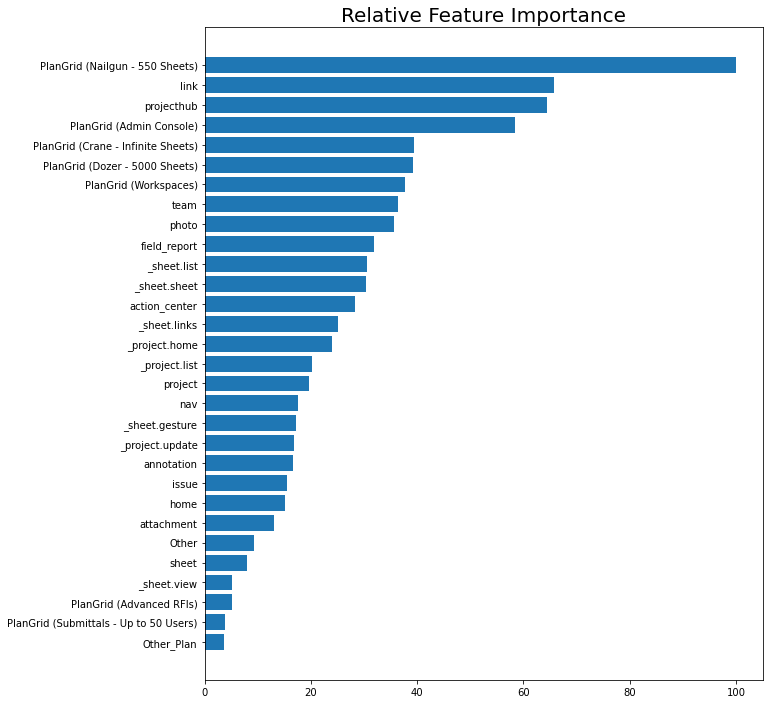

In [417]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier()
random_forest.fit(X_train, Y_train)
importances = random_forest.feature_importances_

feature_importance = 100.0 * (importances / importances.max()) # relative importance
sorted_idx = np.argsort(feature_importance)
feature_names = list(X_train.columns.values)
feature_names_sort = [feature_names[indice] for indice in sorted_idx]
pos = np.arange(sorted_idx.shape[0]) + .5
print ('Top 10 features are: ')
for feature in feature_names_sort[::-1][:10]:
    print (feature)

# plot top features
plt.figure(figsize=(10, 12))
plt.barh(pos[:], feature_importance[sorted_idx[:]], align='center')
plt.yticks(pos[:], feature_names_sort[:])
plt.title('Relative Feature Importance', fontsize=20)
plt.show()

## Future Work

If we have more time, we could improve our model. 

First, we could add "EVENT_COUNT" and "QUANTITY" to our feature set to see if these two improve our model. 

Second, we could add other sampling methods like OverSampling or Undersampling to see if this change improve our model or not.

Third, we could add crossvalidation. Now we see that AUC for validation set is much lower than traning set, and it means our models suffer from overfitting. By adding cross-validaion we can prevent from overfitting.

Fourth, we could add L1 Regularization. It helps us to for feature selection as well as preventing overfitting. 

At last, we could do Hypertuning for each model to imrpove prediction for each model.

### Forecast

In [418]:
df_test

,RENEWAL_DATE_C,IS_WON,Other_Plan,PlanGrid (Admin Console),PlanGrid (Advanced RFIs),PlanGrid (Crane - Infinite Sheets),PlanGrid (Dozer - 5000 Sheets),PlanGrid (Nailgun - 550 Sheets),PlanGrid (Submittals - Up to 50 Users),PlanGrid (Workspaces),...,field_report,home,issue,link,nav,photo,project,projecthub,sheet,team
OPPORTUNITY_ID,,,,,,,,,,,,,,,,,,,,,
opp1,2020-04-23 00:00:00,0.0,0,0,0,0,1,1,0,0,...,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0
opp10,2020-04-23 00:00:00,0.0,0,0,0,1,1,0,0,0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
opp100,2020-04-29 00:00:00,0.0,0,0,0,0,0,1,1,0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
opp102,2020-04-30 00:00:00,0.0,0,0,0,0,1,0,0,0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
opp107,2020-04-21 00:00:00,0.0,0,0,0,0,0,1,0,0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
opp88,2020-04-30 00:00:00,0.0,0,1,0,0,1,1,1,1,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
opp89,2020-04-25 00:00:00,0.0,0,0,0,0,0,1,0,0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
opp9,2020-04-25 00:00:00,0.0,0,1,0,0,1,1,0,0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [419]:
df_test2=df_test.copy()

In [420]:
X_test = df_test2.drop(['RENEWAL_DATE_C','IS_WON'], axis=1)
lr_pred_test = lr.predict_proba(X_test)[:,1]

In [421]:
df_final=df_test2[['RENEWAL_DATE_C']]
df_final.reset_index(inplace=True)
df_final.insert(2, "WIN_PROBABILITY",lr_pred_test , True)
df_final

,OPPORTUNITY_ID,RENEWAL_DATE_C,WIN_PROBABILITY
0,opp1,2020-04-23 00:00:00,0.945845
1,opp10,2020-04-23 00:00:00,0.715583
2,opp100,2020-04-29 00:00:00,0.455370
3,opp102,2020-04-30 00:00:00,0.355503
4,opp107,2020-04-21 00:00:00,0.462653
...,...,...,...
223,opp88,2020-04-30 00:00:00,0.987783
224,opp89,2020-04-25 00:00:00,0.181482
225,opp9,2020-04-25 00:00:00,0.959820
226,opp93,2020-04-23 00:00:00,0.355503


In [422]:
df_final2=df_final.copy()

In [423]:
df_final2['RENEWAL_DATE_C'] = pd.to_datetime(df_final2['RENEWAL_DATE_C']).dt.date


In [424]:
df_final2

,OPPORTUNITY_ID,RENEWAL_DATE_C,WIN_PROBABILITY
0,opp1,2020-04-23,0.945845
1,opp10,2020-04-23,0.715583
2,opp100,2020-04-29,0.455370
3,opp102,2020-04-30,0.355503
4,opp107,2020-04-21,0.462653
...,...,...,...
223,opp88,2020-04-30,0.987783
224,opp89,2020-04-25,0.181482
225,opp9,2020-04-25,0.959820
226,opp93,2020-04-23,0.355503


In [427]:
df_final2.to_csv(r'C:\Users\19498\Desktop\Nikkhah_Result.csv',index=False)

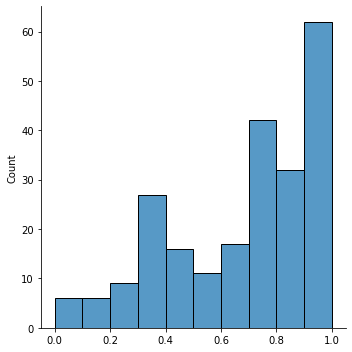

In [432]:
sns.displot(lr_pred_test,bins=[0,0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,0.8,0.9,1])